In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import utils
%matplotlib inline

In [2]:
train_loader = utils.loader(train=True, normalize=True)
test_loader = utils.loader(train=False, normalize=True)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 28*28)
        self._loss = F.mse_loss
        
    def forward(self, x):
        self.x_flatten = x.view(-1, 28*28)
        self.h = F.sigmoid(self.fc1(self.x_flatten))
        self.data_rho = self.h.mean(0)
        self.out = F.tanh(self.fc2(self.h))
        return self.out
    
    def decode(self, x):
        return F.tanh(self.fc2(x))
    
    def rho_loss(self, rho):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        return dkl.mean()
    
    def loss(self, x, target, **kwargs):
        return self._loss(x, target, **kwargs)

In [4]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
sparse = True
rho = 0.05

In [5]:
def train(epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        
        rho_loss = model.rho_loss(rho)    
        loss = model.loss(output, data.view(-1, 784)) + rho_loss
        
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    else:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data[0]))

In [6]:
def test(log=None):
    test_loss = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += model.loss(output, data.view(-1, 784), size_average=False).data[0] # sum up batch loss
    test_loss /= len(test_loader.dataset) * 784
    
    train_loss = 0
    for data, target in train_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        train_loss += model.loss(output, data.view(-1, 784), size_average=False).data[0] # sum up batch loss
    train_loss /= len(train_loader.dataset) * 784
    
    print('Average test/train loss: {:.4f}/{:.4f}\n'.format(test_loss, train_loss))
    
    log['test'].append(test_loss)
    log['train'].append(train_loss)

In [7]:
err_log = {'test': [], 'train': []}

In [8]:
for epoch in range(1, 11):
    train(epoch)
    test(err_log)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.512754
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.485223
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.497519
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.504897
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.454417
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.468589
Train Epoch: 1 [59950/60000 (100%)]	Loss: 0.489132
Average test/train loss: 0.4544/0.4497

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.492526
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.450083
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.481117
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.436841
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.486968
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.435538
Train Epoch: 2 [59950/60000 (100%)]	Loss: 0.456980
Average test/train loss: 0.4525/0.4473

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.459360
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.447373
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.471863
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.500106
Train Epoch: 3 [40000/60000 (67%)

In [9]:
data, target = next(iter(train_loader))
data, target = Variable(data, volatile=True), Variable(target)

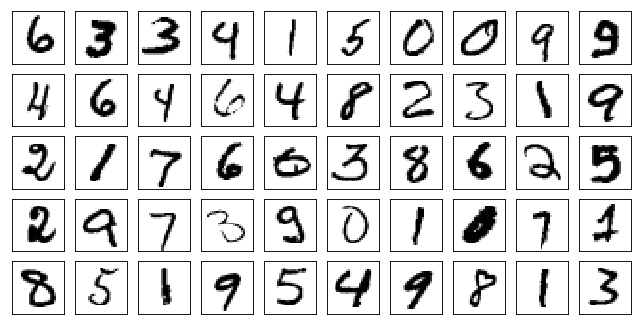

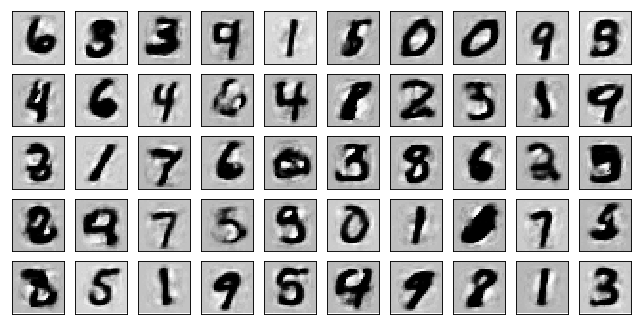

In [10]:
output = model(data)
to_plot = ((output.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
utils.plot_mnist(data.data.numpy(), (10, 5))
utils.plot_mnist(to_plot, (10, 5))

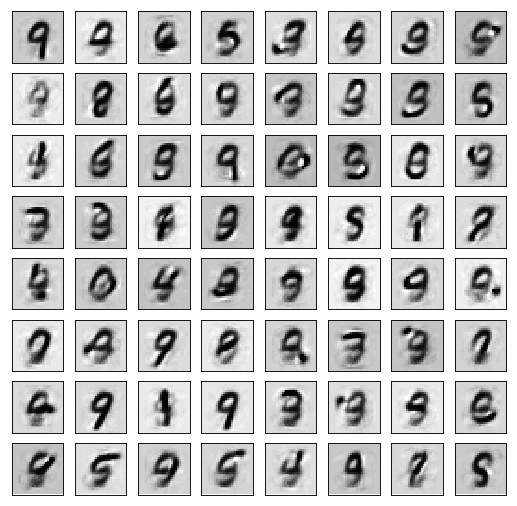

In [11]:
decoded = model.decode(Variable(torch.eye(64)))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
utils.plot_mnist(dec_to_plot, (8, 8))